# Assignment: Visualization
### `! git clone https://github.com/ds3001f25/visualization_assignment.git`
### Do Q1 and Q2.

**Q1.** Write your own function to make a kernel density plot.

- The user should pass in a Pandas series or Numpy array.
- The default kernel should be Gaussian, but include the uniform/bump and Epanechnikov as alternatives.
- The default bandwidth should be the Silverman plug-in, but allow the user to specify an alternative.
- You can use Matplotlib or Seaborn's `.lineplot`, but not an existing function that creates kernel density plots.

You will have to make a lot of choices and experiment with getting errors. Embrace the challenge and track your choices in the comments in your code.

Use the pretrail data set from class to show that your function works, and compare it with the Seaborn `kdeplot`.

We covered the Gaussian,
$$
k(z) = \dfrac{1}{\sqrt{2\pi}}e^{-z^2/2}
$$
and uniform 
$$
k(z) = \begin{cases} 
\frac{1}{2}, & |z| \le 1 \\
0, & |z|>1
\end{cases}
$$
kernels in class, but the Epanechnikov kernel is 
$$
k(z) = \begin{cases} 
\frac{3}{4} (1-z^2), & |z| \le 1 \\
0, & |z|>1.
\end{cases}
$$

In order to make your code run reasonably quickly, consider using the `pdist` or `cdist` functions from SciPy to make distance calculations for arrays of points. The other leading alternative is to thoughtfully use NumPy's broadcasting features. Writing `for` loops will be slow, but that's fine.

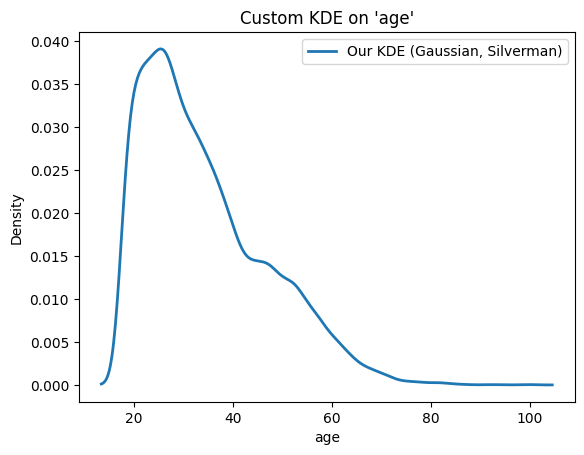

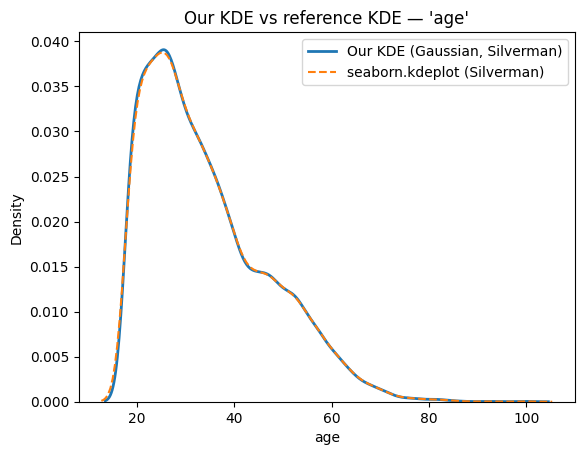

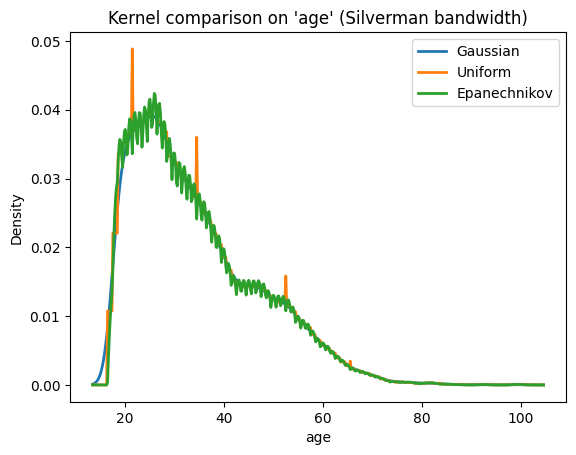

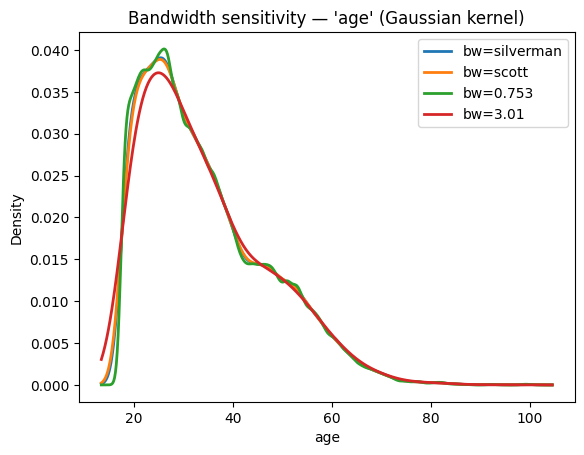

In [ ]:
# Engineering choices:
# - Vectorization: use NumPy broadcasting to evaluate K((x - xi)/h) on a grid
#   in one shot (shape (m, n)).
# - Robust scale: use IQR-based scale in Silverman bandwidth to handle outliers.
# Used age variable from pretrial_data.csv for KOE.

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Union, Optional

try:
    import seaborn as sns
    _HAVE_SEABORN = True
except Exception:
    _HAVE_SEABORN = False

try:
    from scipy.stats import gaussian_kde
    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False


ArrayLike1D = Union[np.ndarray, pd.Series, list, tuple]


def _as_1d_array(x: ArrayLike1D) -> np.ndarray:
    """Coerce to 1D float array, drop NaNs; raise if empty."""
    arr = np.asarray(x, dtype=float).ravel()
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        raise ValueError("Input has no valid (non-NaN) values.")
    return arr


def _iqr(a: np.ndarray) -> float:
    """Interquartile range via percentiles (robust scale)."""
    q75, q25 = np.percentile(a, [75, 25])
    return float(q75 - q25)


def _silverman_bandwidth(a: np.ndarray) -> float:
    """Silverman plug-in bandwidth: 0.9 * min(std, IQR/1.34) * n^(-1/5)."""
    n = a.size
    if n < 2:
        return 1e-6
    s = float(np.std(a, ddof=1))
    iqr = _iqr(a)
    scale = min(s, iqr / 1.34) if (s > 0 or iqr > 0) else s
    if scale == 0:
        return 1e-6
    return 0.9 * scale * (n ** (-1/5))


def _scott_bandwidth(a: np.ndarray) -> float:
    """Scott rule: h = std * n^(-1/5)."""
    n = a.size
    if n < 2:
        return 1e-6
    s = float(np.std(a, ddof=1))
    if s == 0:
        return 1e-6
    return s * (n ** (-1/5))


def _kernel_eval(u: np.ndarray, kernel: str) -> np.ndarray:
    """Elementwise kernel values K(u). Each kernel integrates to 1 over R."""
    k = kernel.lower()
    if k == "gaussian":
        return np.exp(-0.5 * u*u) / np.sqrt(2 * np.pi)
    elif k in ("uniform", "rectangular", "box"):
        out = np.zeros_like(u)
        mask = np.abs(u) <= 1
        out[mask] = 0.5  # integrates to 1 over [-1,1]
        return out
    elif k in ("epanechnikov", "epa"):
        out = np.zeros_like(u)
        mask = np.abs(u) <= 1
        out[mask] = 0.75 * (1 - u[mask]**2)
        return out
    else:
        raise ValueError("Unknown kernel. Choose 'gaussian', 'uniform', or 'epanechnikov'.")


def kde1d(
    x: ArrayLike1D,
    grid: Optional[np.ndarray] = None,
    kernel: str = "gaussian",
    bandwidth: Union[str, float] = "silverman",
    grid_pts: int = 512,
    extend: float = 3.0,
) -> Tuple[np.ndarray, np.ndarray]:
    a = _as_1d_array(x)
    n = a.size

    # Bandwidth
    if isinstance(bandwidth, str):
        b = bandwidth.lower()
        if b == "silverman":
            h = _silverman_bandwidth(a)
        elif b == "scott":
            h = _scott_bandwidth(a)
        else:
            raise ValueError("bandwidth must be 'silverman', 'scott', or a positive float.")
    else:
        h = float(bandwidth)
        if not np.isfinite(h) or h <= 0:
            raise ValueError("Numeric bandwidth must be a positive finite float.")
    h = max(h, 1e-12)  # avoid division by ~0

    # Grid
    if grid is None:
        lo, hi = float(np.min(a)), float(np.max(a))
        lo -= extend * h
        hi += extend * h
        if lo == hi or not np.isfinite(lo) or not np.isfinite(hi):
            c = float(a.mean())
            lo, hi = c - 5*h, c + 5*h
        grid = np.linspace(lo, hi, int(grid_pts))

    # Vectorized evaluation: u = (x_grid - x_i)/h, shape (m, n)
    X = np.asarray(grid, dtype=float).reshape(-1, 1)   # (m,1)
    U = (X - a.reshape(1, -1)) / h                     # (m,n)
    K = _kernel_eval(U, kernel)                        # (m,n)
    dens = K.sum(axis=1) / (n * h)                     # (m,)

    return grid, dens


def kdeplot1d(
    x: ArrayLike1D,
    kernel: str = "gaussian",
    bandwidth: Union[str, float] = "silverman",
    grid: Optional[np.ndarray] = None,
    grid_pts: int = 512,
    extend: float = 3.0,
    label: Optional[str] = None,
    linewidth: float = 2.0,
):
    """Convenience: compute & plot KDE via matplotlib (no seaborn used here)."""
    grid, dens = kde1d(x, grid=grid, kernel=kernel, bandwidth=bandwidth,
                       grid_pts=grid_pts, extend=extend)
    plt.figure()
    plt.plot(grid, dens, linewidth=linewidth, label=label or f"{kernel}, bw={bandwidth}")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.title("Custom KDE")
    if label:
        plt.legend()
    plt.show()
    return grid, dens



CSV_PATH = "./data/pretrial_data.csv"
TARGET_COLUMN = "age" 

df = pd.read_csv(CSV_PATH)
x = df[TARGET_COLUMN].to_numpy()
x = x[~np.isnan(x)]  # drop NaNs

# 1) Our KDE (Gaussian + Silverman)
grid, dens = kde1d(x, kernel="gaussian", bandwidth="silverman")
plt.figure()
plt.plot(grid, dens, linewidth=2.0, label="Our KDE (Gaussian, Silverman)")
plt.xlabel(TARGET_COLUMN)
plt.ylabel("Density")
plt.title(f"Custom KDE on '{TARGET_COLUMN}'")
plt.legend()
plt.show()

# 2) Compare with seaborn.kdeplot
plt.figure()
plt.plot(grid, dens, linewidth=2.0, label="Our KDE (Gaussian, Silverman)")
if _HAVE_SEABORN:
    try:
        sns.kdeplot(x=x, bw_method="silverman", fill=False, linestyle="--", label="seaborn.kdeplot (Silverman)")
    except TypeError:
        sns.kdeplot(x=x, fill=False, linestyle="--", label="seaborn.kdeplot (default bw)")
elif _HAVE_SCIPY:
    # SciPy proxy for seaborn (forces Silverman)
    sc = gaussian_kde(dataset=x, bw_method="silverman")
    plt.plot(grid, sc(grid), linestyle="--", linewidth=1.5, label="SciPy gaussian_kde (Silverman)")
else:
    print("Warning: neither seaborn nor scipy available; skipping comparison overlay.")
plt.xlabel(TARGET_COLUMN); plt.ylabel("Density")
plt.title(f"Our KDE vs reference KDE — '{TARGET_COLUMN}'")
plt.legend(); plt.show()

# 3) Kernel comparison at the same bandwidth (Silverman)
plt.figure()
for kname in ["gaussian", "uniform", "epanechnikov"]:
    g, d = kde1d(x, kernel=kname, bandwidth="silverman", grid=grid)
    plt.plot(g, d, linewidth=2.0, label=kname.capitalize())
plt.xlabel(TARGET_COLUMN); plt.ylabel("Density")
plt.title(f"Kernel comparison on '{TARGET_COLUMN}' (Silverman bandwidth)")
plt.legend(); plt.show()

# 4) Bandwidth sensitivity (Gaussian)
h_s = _silverman_bandwidth(_as_1d_array(x))
bws = ["silverman", "scott", 0.5*h_s, 2.0*h_s]
plt.figure()
for bw in bws:
    g, d = kde1d(x, kernel="gaussian", bandwidth=bw, grid=grid)
    lbl = f"bw={bw}" if isinstance(bw, str) else f"bw={bw:.3g}"
    plt.plot(g, d, linewidth=2.0, label=lbl)
plt.xlabel(TARGET_COLUMN); plt.ylabel("Density")
plt.title(f"Bandwidth sensitivity — '{TARGET_COLUMN}' (Gaussian kernel)")
plt.legend(); plt.show()


**Q2.** This question provides some practice doing exploratory data analysis and visualization.

The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `./data/college_completion.csv` data with Pandas.
2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see.
4. For `grad_100_value`, create a histogram, kernel density plot, boxplot, and statistical description.
5. For `grad_100_value`, create a grouped kernel density plot by `control` and by `level`. Describe what you see. Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `grad_100_value` by `level` and `control`. Which institutions appear to have the best graduation rates?
6. Create a new variable, `df['levelXcontrol']=df['level']+', '+df['control']` that interacts level and control. Make a grouped kernel density plot. Which institutions appear to have the best graduation rates?
7. Make a kernel density plot of `aid_value`. Now group your graph by `level` and `control`. What explains the shape of the graph? Use `groupby` and `.describe` to make grouped calculations of statistical descriptions of `aid_value` by `level` and `control`.
8. Make a scatterplot of `grad_100_value` by `aid_value`. Describe what you see. Now make the same plot, grouping by `level` and then `control`. Describe what you see. For which kinds of institutions does aid seem to increase graduation rates?


[2] Dimensions & variables
Dimensions: 3798 rows × 63 columns
Columns: ['index', 'unitid', 'chronname', 'city', 'state', 'level', 'control', 'basic', 'hbcu', 'flagship', 'long_x', 'lat_y', 'site', 'student_count', 'awards_per_value', 'awards_per_state_value', 'awards_per_natl_value', 'exp_award_value', 'exp_award_state_value', 'exp_award_natl_value', 'exp_award_percentile', 'ft_pct', 'fte_value', 'fte_percentile', 'med_sat_value', 'med_sat_percentile', 'aid_value', 'aid_percentile', 'endow_value', 'endow_percentile', 'grad_100_value', 'grad_100_percentile', 'grad_150_value', 'grad_150_percentile', 'pell_value', 'pell_percentile', 'retain_value', 'retain_percentile', 'ft_fac_value', 'ft_fac_percentile', 'vsa_year', 'vsa_grad_after4_first', 'vsa_grad_elsewhere_after4_first', 'vsa_enroll_after4_first', 'vsa_enroll_elsewhere_after4_first', 'vsa_grad_after6_first', 'vsa_grad_elsewhere_after6_first', 'vsa_enroll_after6_first', 'vsa_enroll_elsewhere_after6_first', 'vsa_grad_after4_transfer',

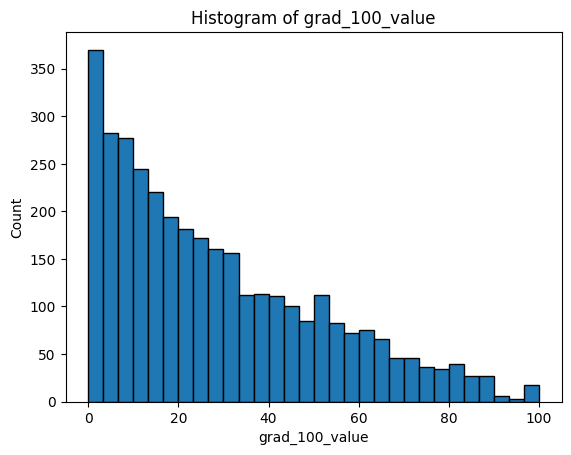

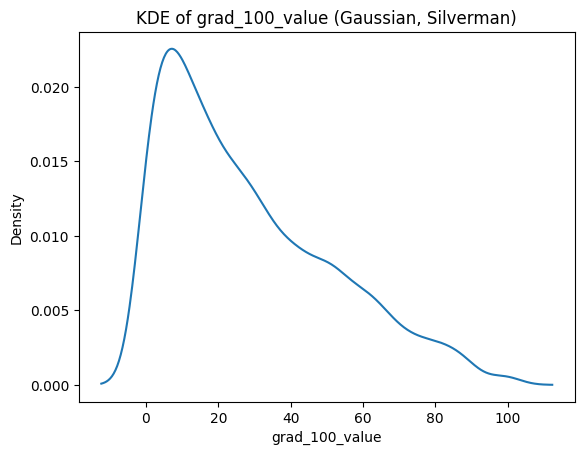

/var/folders/sc/4x1k3r3n61d13_20pq4s_18m0000gn/T/ipykernel_98091/3104478840.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grad, vert=True, labels=["grad_100_value"])


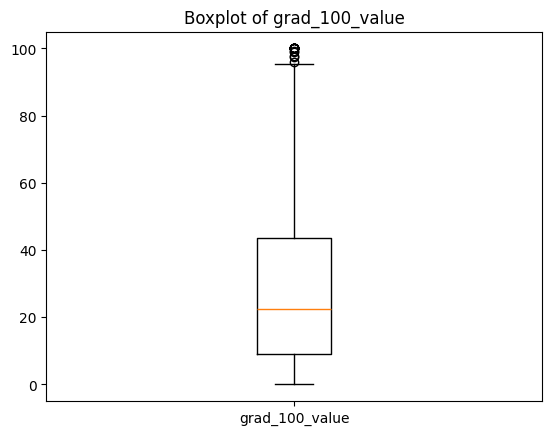


Describe (grad_100_value):
count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
dtype: float64

[5] Grouped KDEs for grad_100_value by control and by level


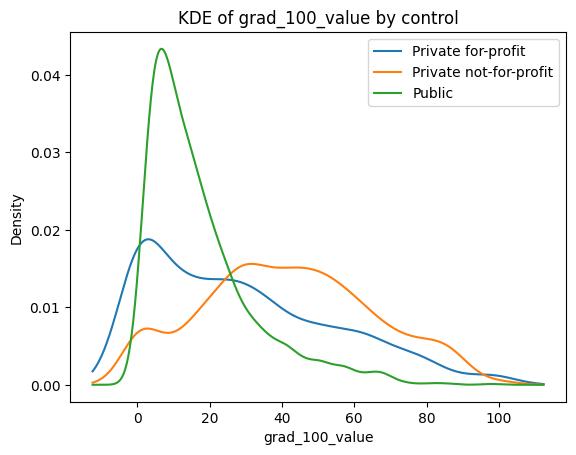

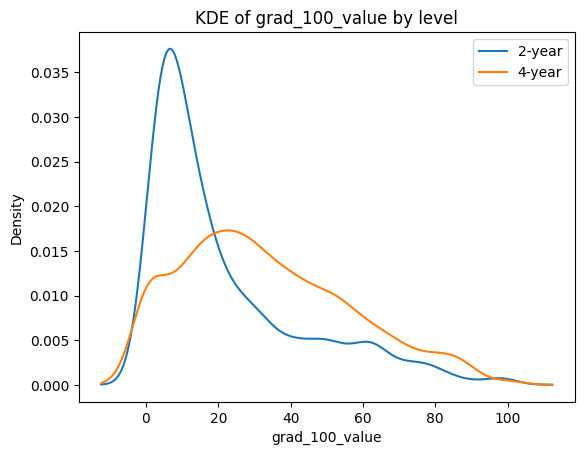


Grouped describe of grad_100_value by control:
                         count       mean        std  min    25%   50%    75%  \
control                                                                         
Private for-profit       779.0  29.108858  25.601687  0.0   6.95  24.7  46.75   
Private not-for-profit  1189.0  41.660976  23.551231  0.0  25.00  41.0  58.30   
Public                  1499.0  17.430887  14.729443  0.0   6.90  13.2  23.25   

                          max  
control                        
Private for-profit      100.0  
Private not-for-profit  100.0  
Public                   97.8  

Grouped describe of grad_100_value by level:
         count       mean        std  min   25%   50%     75%    max
level                                                               
2-year  1455.0  21.636151  21.645747  0.0   6.0  13.0  30.600  100.0
4-year  2012.0  33.230119  23.270160  0.0  15.2  29.7  49.225  100.0

[6] KDE of grad_100_value by levelXcontrol


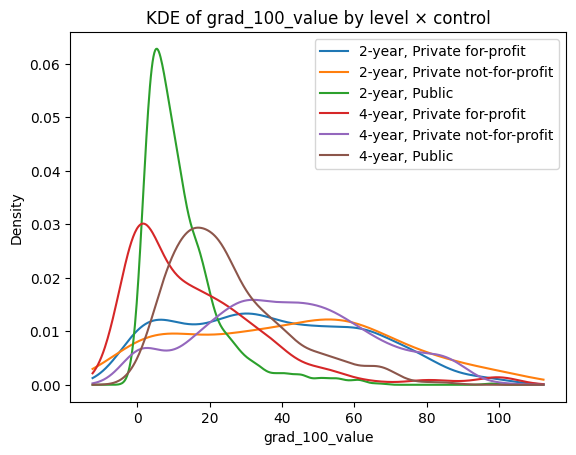


[7] aid_value KDEs and grouped stats


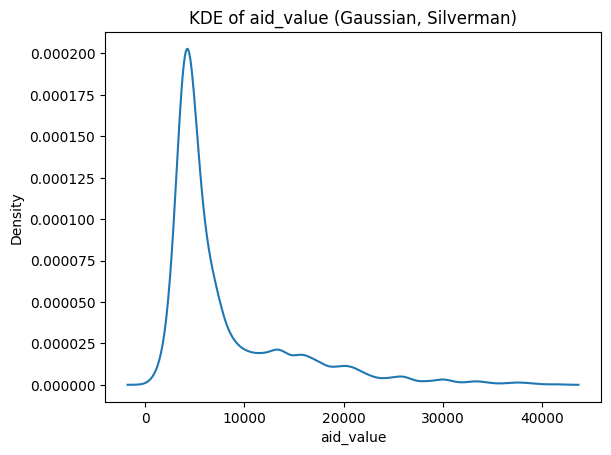

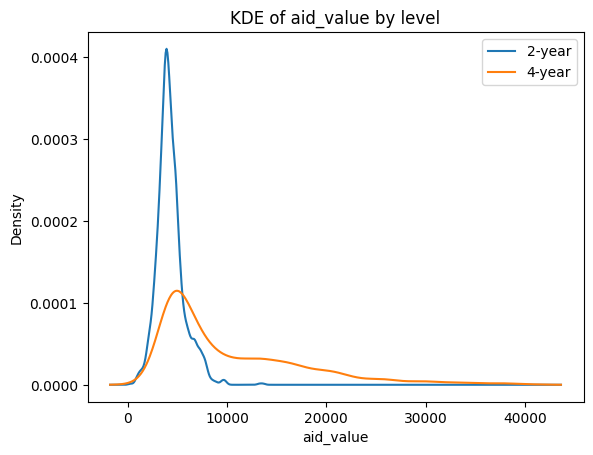

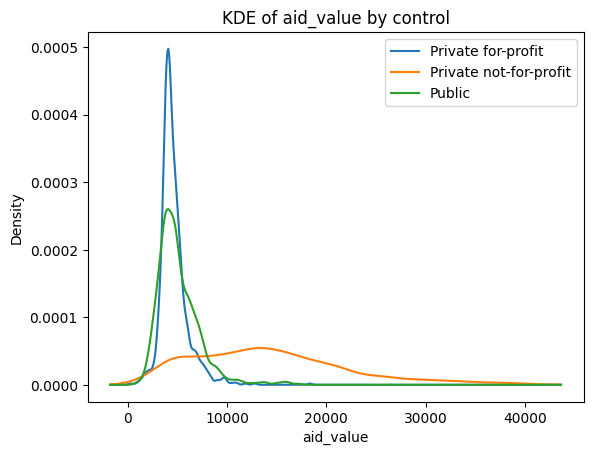


Grouped describe of aid_value by level:
         count          mean          std    min     25%     50%      75%  \
level                                                                       
2-year  1458.0   4310.878601  1384.045631  294.0  3485.5  4113.0   4890.0   
4-year  2339.0  10235.379222  7227.369167  902.0  4830.5  7222.0  14046.0   

            max  
level            
2-year  13654.0  
4-year  41580.0  

Grouped describe of aid_value by control:
                         count          mean          std    min      25%  \
control                                                                     
Private for-profit       991.0   4632.206862  1399.121259  294.0  3861.50   
Private not-for-profit  1248.0  14180.722756  7772.700998  902.0  8325.00   
Public                  1558.0   5094.835687  2136.436370  881.0  3725.25   

                            50%      75%      max  
control                                            
Private for-profit       4331.0   5131.5  183

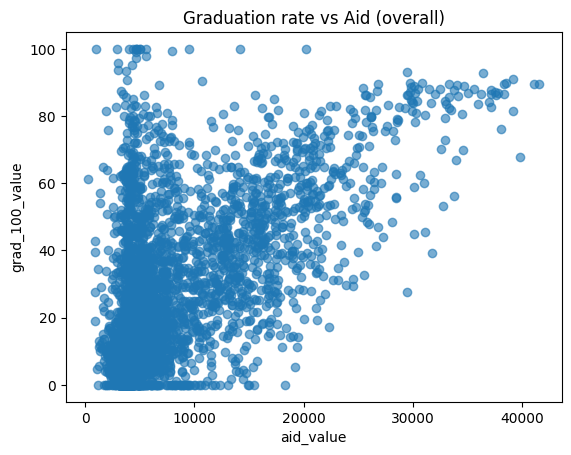

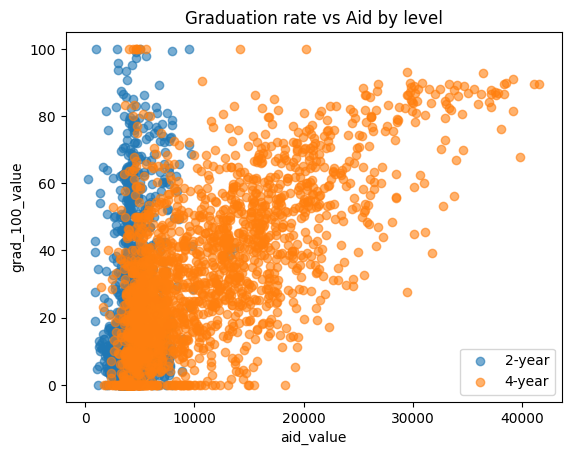

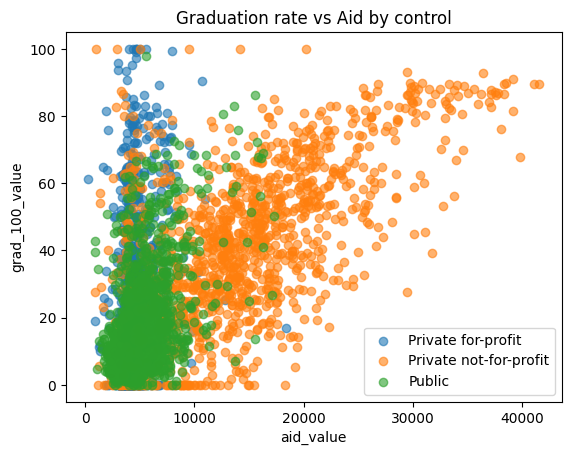

Pearson correlation (overall) aid_value vs grad_100_value: 0.576
Pearson correlation aid_value vs grad_100_value by level:
  2-year: 0.211
  4-year: 0.670
Pearson correlation aid_value vs grad_100_value by control:
  Private for-profit: 0.188
  Private not-for-profit: 0.602
  Public: 0.482


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union

def _as_1d_array(x):
    arr = np.asarray(x, dtype=float).ravel()
    arr = arr[~np.isnan(arr)]
    if arr.size == 0:
        raise ValueError("Input has no valid (non-NaN) values.")
    return arr

def _iqr(a: np.ndarray) -> float:
    q75, q25 = np.percentile(a, [75, 25])
    return float(q75 - q25)

def _silverman_bandwidth(a: np.ndarray) -> float:
    n = a.size
    if n < 2:
        return 1e-6
    s = float(np.std(a, ddof=1))
    iqr = _iqr(a)
    scale = min(s, iqr/1.34) if (s > 0 or iqr > 0) else s
    if scale == 0:
        return 1e-6
    return 0.9 * scale * (n ** (-1/5))

def _kernel_eval(u: np.ndarray, kernel: str) -> np.ndarray:
    k = kernel.lower()
    if k == "gaussian":
        return np.exp(-0.5 * u*u) / np.sqrt(2*np.pi)
    elif k in ("uniform","rectangular","box"):
        out = np.zeros_like(u); m = (np.abs(u) <= 1); out[m] = 0.5; return out
    elif k in ("epanechnikov","epa"):
        out = np.zeros_like(u); m = (np.abs(u) <= 1); out[m] = 0.75*(1-u[m]**2); return out
    else:
        raise ValueError("Unknown kernel.")

def kde1d(x,
          kernel: str="gaussian",
          bandwidth: Union[str,float]="silverman",
          grid: Optional[np.ndarray]=None,
          grid_pts: int=512,
          extend: float=3.0) -> Tuple[np.ndarray, np.ndarray]:
    """Return (grid, density) for a 1D KDE with given kernel and bandwidth."""
    a = _as_1d_array(x); n = a.size
    if isinstance(bandwidth, str):
        if bandwidth.lower() == "silverman":
            h = _silverman_bandwidth(a)
        else:
            raise ValueError("Only 'silverman' or numeric bandwidth supported here.")
    else:
        h = float(bandwidth)
        if not np.isfinite(h) or h <= 0:
            raise ValueError("Bandwidth must be positive & finite.")
    h = max(h, 1e-12)
    if grid is None:
        lo, hi = float(np.min(a))-extend*h, float(np.max(a))+extend*h
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            c = float(a.mean()); lo, hi = c-5*h, c+5*h
        grid = np.linspace(lo, hi, grid_pts)
    U = (grid.reshape(-1,1) - a.reshape(1,-1)) / h
    K = _kernel_eval(U, kernel)
    dens = K.sum(axis=1) / (n*h)
    return grid, dens

# 1) Load data

path = "./data/college_completion.csv"

df = pd.read_csv(path)
df.columns = [c.strip() for c in df.columns]

# 2) Dimensions, variables, head
print("\n[2] Dimensions & variables")
n_rows, n_cols = df.shape
print(f"Dimensions: {n_rows} rows × {n_cols} columns")
print("Columns:", df.columns.tolist())
print("\nHead:")
print(df.head())

# 3) Cross-tabulate control × level
print("\n[3] Crosstab: control × level")
ct = pd.crosstab(df["control"], df["level"], dropna=False)
print(ct)

# 4) grad_100_value visuals + describe
print("\n[4] grad_100_value visuals & summary")
grad = df["grad_100_value"].astype(float).dropna().values

# Histogram
plt.figure()
plt.hist(grad, bins=30, edgecolor="black")
plt.xlabel("grad_100_value"); plt.ylabel("Count"); plt.title("Histogram of grad_100_value")
plt.show()

# KDE (Gaussian + Silverman)
ggrid, gdens = kde1d(grad, kernel="gaussian", bandwidth="silverman")
plt.figure()
plt.plot(ggrid, gdens)
plt.xlabel("grad_100_value"); plt.ylabel("Density"); plt.title("KDE of grad_100_value (Gaussian, Silverman)")
plt.show()

# Boxplot
plt.figure()
plt.boxplot(grad, vert=True, labels=["grad_100_value"])
plt.title("Boxplot of grad_100_value")
plt.show()

print("\nDescribe (grad_100_value):")
print(pd.Series(grad).describe())

# 5) Grouped KDEs + grouped describes
def grouped_kde_plot(df, value_col: str, group_col: str, title: str, base_grid=None):
    groups = df[group_col].astype(str).fillna("NA").unique()
    plt.figure()
    for g in sorted(groups):
        vals = df.loc[df[group_col] == g, value_col].astype(float).dropna().values
        if vals.size < 3:
            continue
        grid, dens = kde1d(vals, kernel="gaussian", bandwidth="silverman", grid=base_grid)
        plt.plot(grid, dens, label=str(g))
        base_grid = grid
    plt.xlabel(value_col); plt.ylabel("Density"); plt.title(title); plt.legend()
    plt.show()

print("\n[5] Grouped KDEs for grad_100_value by control and by level")
grouped_kde_plot(df, "grad_100_value", "control", "KDE of grad_100_value by control", base_grid=ggrid)
grouped_kde_plot(df, "grad_100_value", "level", "KDE of grad_100_value by level", base_grid=ggrid)

print("\nGrouped describe of grad_100_value by control:")
print(df.groupby("control", dropna=False)["grad_100_value"].describe())

print("\nGrouped describe of grad_100_value by level:")
print(df.groupby("level", dropna=False)["grad_100_value"].describe())

# 6) Interaction levelXcontrol + grouped KDE
print("\n[6] KDE of grad_100_value by levelXcontrol")
df["levelXcontrol"] = df["level"].astype(str) + ", " + df["control"].astype(str)
grouped_kde_plot(df, "grad_100_value", "levelXcontrol", "KDE of grad_100_value by level × control", base_grid=ggrid)

# 7) aid_value KDEs + grouped describes
print("\n[7] aid_value KDEs and grouped stats")
aid = df["aid_value"].astype(float).dropna().values

plt.figure()
agrid, adens = kde1d(aid, kernel="gaussian", bandwidth="silverman")
plt.plot(agrid, adens)
plt.xlabel("aid_value"); plt.ylabel("Density"); plt.title("KDE of aid_value (Gaussian, Silverman)")
plt.show()

grouped_kde_plot(df, "aid_value", "level", "KDE of aid_value by level", base_grid=agrid)
grouped_kde_plot(df, "aid_value", "control", "KDE of aid_value by control", base_grid=agrid)

print("\nGrouped describe of aid_value by level:")
print(df.groupby("level", dropna=False)["aid_value"].describe())

print("\nGrouped describe of aid_value by control:")
print(df.groupby("control", dropna=False)["aid_value"].describe())

# 8) Scatterplots grad_100_value vs aid_value
print("\n[8] Scatterplots: grad_100_value vs aid_value")

def grouped_scatter(df, xcol: str, ycol: str, group: str, title: str):
    plt.figure()
    for g, sub in df.groupby(group, dropna=False):
        plt.scatter(sub[xcol], sub[ycol], alpha=0.6, label=str(g))
    plt.xlabel(xcol); plt.ylabel(ycol); plt.title(title); plt.legend()
    plt.show()

# Overall
plt.figure()
plt.scatter(df["aid_value"], df["grad_100_value"], alpha=0.6)
plt.xlabel("aid_value"); plt.ylabel("grad_100_value"); plt.title("Graduation rate vs Aid (overall)")
plt.show()

# By level
grouped_scatter(df, "aid_value", "grad_100_value", "level", "Graduation rate vs Aid by level")

# By control
grouped_scatter(df, "aid_value", "grad_100_value", "control", "Graduation rate vs Aid by control")

def print_corrs(df, xcol, ycol, by=None):
    if by is None:
        temp = df[[xcol, ycol]].astype(float).dropna()
        c = temp[xcol].corr(temp[ycol])
        print(f"Pearson correlation (overall) {xcol} vs {ycol}: {c:.3f}")
    else:
        print(f"Pearson correlation {xcol} vs {ycol} by {by}:")
        for g, sub in df.groupby(by, dropna=False):
            temp = sub[[xcol, ycol]].astype(float).dropna()
            c = temp[xcol].corr(temp[ycol]) if len(temp) > 1 else np.nan
            if np.isfinite(c):
                print(f"  {g}: {c:.3f}")
            else:
                print(f"  {g}: insufficient data")

print_corrs(df, "aid_value", "grad_100_value")
print_corrs(df, "aid_value", "grad_100_value", by="level")
print_corrs(df, "aid_value", "grad_100_value", by="control")

1. Code above.

2. The dataset has 3,798 rows and 63 columns, and 3,798 observations. The variables include identifiers (unitid, chronname), geography (city, state), characteristics (level, control, basic), student outcomes (grad_100_value, grad_150_value, retain_value), and financials (aid_value, endow_value, pell_value).

3. Looking at the cross tabulation, the patterns show that public institutions skew toward 2-year (926 two-year vs 632 four-year). Private not-for-profit institutions are mostly 4-year (1,180 four-year vs 68 two-year), and private for-profit institutions are spread across both 2-year (465) and 4-year (527). You can also see that community colleges are mostly public and four-year higher-quality universities tend to be private not-for-profit.

4. Code above

5. Code above. Private not-for-profit have the highest graduation rates (mean ~ 42%), For-profit are moderate (mean ~ 29%), but very spread out, while Public has the lowest (mean ~ 17%). Overall, 4 year institutions do better than 2 year. 4-year, private not-for-profit have the highest graduation rate.

6. 4-year private not-for-profits have the best graduation rates.

7. Code above. The grouping explains the shape of the graph, as 2 year schools have much lower aid, while 4 year schools have higher aid. The shape comes from mixing very different aid distributions across institution types.

8. Overall, there is a moderate positive relationship — higher aid tends to be associated with higher graduation rates. Aid appears to increase graduation rates the most in 4-year, private not-for-profit institutions. In 2-year and for-profit schools, aid has little effect.